# Time Series forecasting on solar irradiance data
----------------------------------------------------

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
import sklearn

import numpy


#Plotting parameters
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,8)


#### Loading the two datasets (climacell and weather from plant)

In [2]:
climacell =  pd.read_csv('climacell_data_formodel.csv')
df = pd.read_csv('weather_data_from_plant.csv')

In [3]:
climacell

,date_time,date,time,irradiance,ambient_temp,wind_speed
0,2020-08-20 06:05:00+05:30,20-08-2020,06:05:00,0,28.58,6.33
1,2020-08-20 06:10:00+05:30,20-08-2020,06:10:00,0,28.57,6.26
2,2020-08-20 06:15:00+05:30,20-08-2020,06:15:00,0,28.57,6.18
3,2020-08-20 06:20:00+05:30,20-08-2020,06:20:00,0,28.56,6.11
4,2020-08-20 06:25:00+05:30,20-08-2020,06:25:00,0,28.56,6.03
...,...,...,...,...,...,...
2947,2020-10-20 11:40:00+05:30,20-10-2020,11:40:00,322,30.24,3.10
2948,2020-10-20 11:45:00+05:30,20-10-2020,11:45:00,322,30.25,3.14
2949,2020-10-20 11:50:00+05:30,20-10-2020,11:50:00,322,30.26,3.19
2950,2020-10-20 11:55:00+05:30,20-10-2020,11:55:00,322,30.26,3.24


In [4]:
climacell.date_time.str[:10].unique()

array(['2020-08-20', '2020-08-23', '2020-08-24', '2020-08-25',
       '2020-09-01', '2020-09-03', '2020-09-05', '2020-09-12',
       '2020-09-18', '2020-09-22', '2020-09-23', '2020-09-24',
       '2020-09-25', '2020-09-30', '2020-10-01', '2020-10-02',
       '2020-10-03', '2020-10-04', '2020-10-05', '2020-10-06',
       '2020-10-07', '2020-10-08', '2020-10-09', '2020-10-10',
       '2020-10-11', '2020-10-12', '2020-10-16', '2020-10-17',
       '2020-10-18', '2020-10-19', '2020-10-20'], dtype=object)

Note: As we can see above that the climacell data only consists of predictions for some dates, so as of now I have decided to create my model only using the other dataset

### Dataset: Weather Station Data

In [5]:
df

,date_time,ambient_temp,wind_speed,irradiance
0,2020-08-21T06:26:01.000Z,28.185780,0.28164,0.000000
1,2020-08-21T06:27:01.000Z,28.185780,0.28164,0.000000
2,2020-08-21T06:28:01.000Z,28.185780,0.28164,0.000000
3,2020-08-21T06:29:01.000Z,28.185780,0.28164,0.000000
4,2020-08-21T06:30:01.000Z,28.170719,0.28164,3.442247
...,...,...,...,...
79907,2020-10-20T12:57:01.000Z,36.253342,0.28164,749.843811
79908,2020-10-20T12:58:01.000Z,36.238201,1.88136,753.283386
79909,2020-10-20T12:59:01.000Z,36.088779,0.28164,753.283386
79910,2020-10-20T13:00:01.000Z,35.983109,0.28164,753.283386


#### Checking if any data is missing

In [6]:
df = df.fillna(0)
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79912 entries, 0 to 79911
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date_time     79912 non-null  object 
 1   ambient_temp  79912 non-null  float64
 2   wind_speed    79912 non-null  float64
 3   irradiance    79912 non-null  float64
dtypes: float64(3), object(1)
memory usage: 2.4+ MB


### Converting to pandas datetime object and using it as index for dataframe

In [7]:
df['date_time'] = pd.to_datetime(df['date_time']).dt.tz_convert('Asia/Kolkata')
df = df.set_index('date_time')
df.head()

,ambient_temp,wind_speed,irradiance
date_time,,,
2020-08-21 11:56:01+05:30,28.185780,0.28164,0.000000
2020-08-21 11:57:01+05:30,28.185780,0.28164,0.000000
2020-08-21 11:58:01+05:30,28.185780,0.28164,0.000000
2020-08-21 11:59:01+05:30,28.185780,0.28164,0.000000
2020-08-21 12:00:01+05:30,28.170719,0.28164,3.442247


In [8]:
df

,ambient_temp,wind_speed,irradiance
date_time,,,
2020-08-21 11:56:01+05:30,28.185780,0.28164,0.000000
2020-08-21 11:57:01+05:30,28.185780,0.28164,0.000000
2020-08-21 11:58:01+05:30,28.185780,0.28164,0.000000
2020-08-21 11:59:01+05:30,28.185780,0.28164,0.000000
2020-08-21 12:00:01+05:30,28.170719,0.28164,3.442247
...,...,...,...
2020-10-20 18:27:01+05:30,36.253342,0.28164,749.843811
2020-10-20 18:28:01+05:30,36.238201,1.88136,753.283386
2020-10-20 18:29:01+05:30,36.088779,0.28164,753.283386


### Sample the dataset using 1 Hour, 15 Minute and 5 Minute frequency

In [9]:
df_hour = df.asfreq('H')
df_15min = df.asfreq('15T')
df_5min = df.asfreq('5T')

In [10]:
print(df_hour.shape)
print(df_15min.shape)
print(df_5min.shape)

(1447, 3)
(5787, 3)
(17360, 3)


### Plotting the data for 1st October 2020 from 3 sampled datasets

In [11]:
data1 = df_hour['2020-10-01']
data2 = df_15min['2020-10-01']
data3 = df_5min['2020-10-01']

print(data1.shape)  #24 hours
print(data2.shape)  #24*4 15 minute intervals
print(data3.shape)  #24*60/5 5 minute intervals

(24, 3)
(96, 3)
(288, 3)


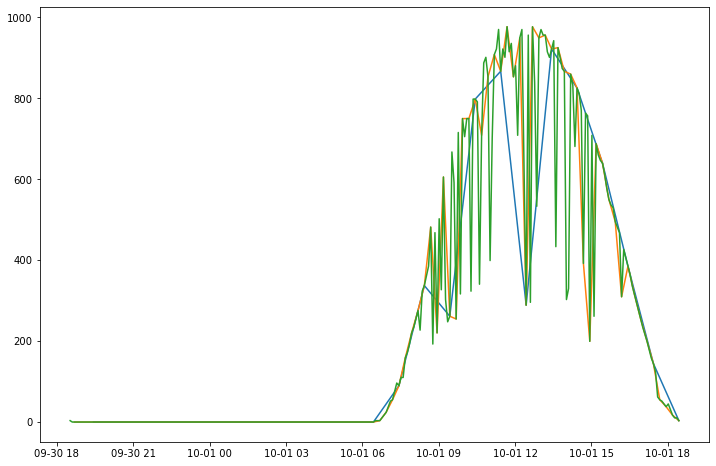

In [12]:
plt.plot(data1.irradiance)
plt.plot(data2.irradiance)
plt.plot(data3.irradiance)

## Splitting the dataset

70% - Training dataset
30% - Test/Validation dataset

In [13]:
def split_dataset(dataset):
    split = int(dataset.shape[0]*0.7)
    train_df = dataset[:split]
    test_df = dataset[split:]

    return train_df,test_df

In [14]:
train_hour_df,test_hour_df = split_dataset(df_hour)
train_15m_df,test_15m_df = split_dataset(df_15min)
train_5m_df,test_5m_df = split_dataset(df_5min)


In [15]:
print(train_hour_df.shape, " " ,test_hour_df.shape)
print(train_15m_df.shape, " " ,test_15m_df.shape)
print(train_5m_df.shape, " " ,test_5m_df.shape)

(1012, 3)   (435, 3)
(4050, 3)   (1737, 3)
(12152, 3)   (5208, 3)


In [16]:
from sklearn import metrics

def print_score(pred,actual):
    print("Root Mean Squared Error : ",np.sqrt(keras.metrics.mean_squared_error(pred,actual).numpy()))
    print("Mean Absolute Error : ",keras.metrics.mean_absolute_error(pred,actual).numpy())
    print("Mean Absolute Percentage Error : ",keras.metrics.mean_absolute_percentage_error(pred,actual).numpy())

    print("R2 Score : ",sklearn.metrics.r2_score(pred,actual))

## Statistical ARIMA Model

------------------------------

In [17]:
from statsmodels.tsa.arima_model import ARIMA

In [18]:
import tensorflow as tf
import numpy as np

### Converting Time Series to windowed dataset

In [19]:
#Multivariate multioutput window
def mmo_window(s,ws,wo):
    #ws : window size
    #wo : output step size

    X = list()
    y = list()

    for i in range(len(s)):
        #Window from i to i+ws
        end_ix = i + ws
        if end_ix > len(s) - 1:
            break
        
        end_ix_o = end_ix + wo
        if end_ix_o > len(s):
            break

        seq_x = s[i:end_ix].fillna(0)
        seq_y = s.iloc[end_ix:end_ix_o,-1].fillna(0)

        X.append(seq_x)
        y.append(seq_y)

    X = np.array(X)
    y = np.array(y)
    return X,y

In [21]:
#window = no of input samples feeded to the model
#step = no of samples predicted into future

window_hour = 24
step_hour = 24

window_15m = 96
step_15m = 96

window_5m = 30
step_5m = 30

X_hour_train,y_hour_train = mmo_window(train_hour_df,window_hour,step_hour)
X_hour_test,y_hour_test = mmo_window(test_hour_df,window_hour,step_hour)

X_15m_train,y_15m_train = mmo_window(train_15m_df,window_15m,step_15m)
X_15m_test,y_15m_test = mmo_window(test_15m_df,window_15m,step_15m)

X_5m_train,y_5m_train = mmo_window(train_5m_df,window_5m,step_5m)
X_5m_test,y_5m_test = mmo_window(test_5m_df,window_5m,step_5m)


### Reshape the input from (rows,window,no_of_columns) to (rows,window*no_of_columns)

#### No of nuerons in input layer = window*no_of_columns

In [68]:
inp_shape = X_train.shape[1]*X_train.shape[2]

Xtrain = X_train
Xtest = X_test

X_train = X_train.reshape((X_train.shape[0],inp_shape))
X_test = X_test.reshape((X_test.shape[0],inp_shape))

print(X_train.shape, " ", X_test.shape)

(965, 72)   (388, 72)


In [87]:
y_5m_test.shape

(5149, 30)

##### Evaluating the Model

In [74]:
def evaluate_forecasts(actual, predicted):
	
    rss = 0
    tss = 0
    y_mean = 0

    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            y_mean += actual[row, col] - predicted[row, col]
    y_mean = y_mean / (actual.shape[0] * actual.shape[1])


    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            rss += (actual[row, col] - predicted[row, col])**2
            tss += (actual[row, col] - y_mean)**2
            

    mse = np.sqrt(rss / (actual.shape[0] * actual.shape[1]))
    r2 = 1 - (rss/tss)

    print("Mean Squared Error : ",mse)
    print("R2 Score : ",r2)


### MLP Model
##### Input Nuerons = Window size * no of features (3 in this case)
##### Output Nuerons = step size


In [75]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [93]:
from tensorflow.keras import optimizers

def mlp(trainX,trainy,testX,testy):
    
    inp_shape = trainX.shape[1]*trainX.shape[2]

    trainX = trainX.reshape(trainX.shape[0],inp_shape)  
    testX = testX.reshape(testX.shape[0],inp_shape)

    #Defining MLP Model
    model = Sequential()
    model.add(Dense(100,activation='relu',input_dim=inp_shape))
    model.add(Dense(trainy.shape[1]))
    model.compile(optimizer='adam',loss='mse')

    #Fitting it with train data
    model.fit(trainX.reshape(trainX.shape[0],inp_shape),trainy,epochs=30,verbose=0)

    #Predicting and evaluating it on test accuracy
    ypred = model.predict(testX)

    evaluate_forecasts(ypred,testy)

    

    plt.plot(ypred[-1],label='Predicted',marker='o')
    plt.plot(testy[-1],label='Actual')
    plt.title("1 Day prediction vs Actual Irradiance Value for the most recent day")
    plt.legend()


Mean Squared Error :  86.8292923904114
R2 Score :  0.9417409470896442


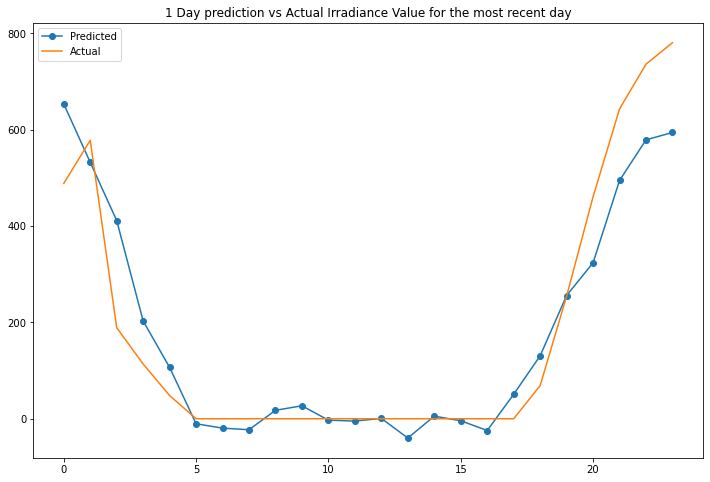

In [94]:
mlp(X_hour_train,y_hour_train,X_hour_test,y_hour_test)

Mean Squared Error :  102.42050883732652
R2 Score :  0.9165414535701577


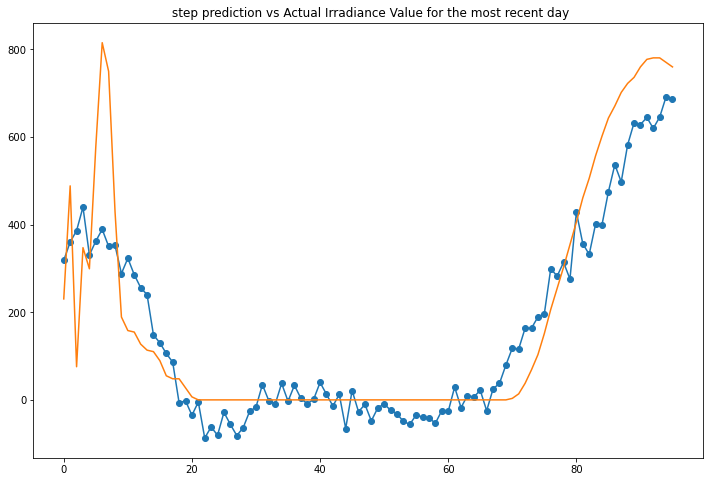

In [90]:
mlp(X_15m_train,y_15m_train,X_15m_test,y_15m_test)

Mean Squared Error :  90.21266353805302
R2 Score :  0.9376276330326389


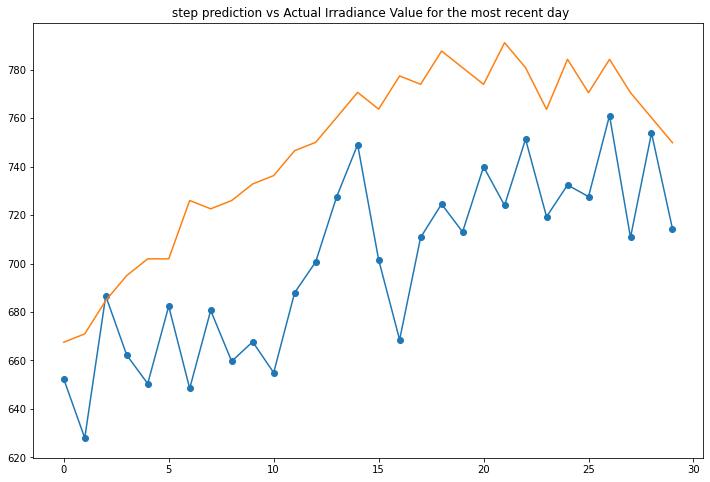

In [91]:
mlp(X_5m_train,y_5m_train,X_5m_test,y_5m_test)

## LSTM

In [104]:
def lstm(trainX,trainy,testX,testy):
    
    inp_shape = trainX.shape[1]*trainX.shape[2]

    #trainX = trainX.reshape(trainX.shape[0],inp_shape)  
    #testX = testX.reshape(testX.shape[0],inp_shape)

    model = Sequential()
    model.add(LSTM(200,input_shape=(trainX.shape[1],trainX.shape[2])))
    model.add(Dense(100,activation='relu'))
    #lstm.add(Dropout(0.2))
    model.add(Dense(trainy.shape[1]))
    model.compile(loss='mse',optimizer='adam')

    #Fitting it with train data
    model.fit(trainX,trainy,epochs=50,batch_size=24,verbose=0)

    #Predicting and evaluating it on test accuracy
    ypred = model.predict(testX)

    evaluate_forecasts(ypred,testy)

    

    plt.plot(ypred[-1],label='Predicted',marker='o')
    plt.plot(testy[-1],label='Actual')
    plt.title("1 Day prediction vs Actual Irradiance Value for the most recent day")
    plt.legend()

Mean Squared Error :  98.21907268257739
R2 Score :  0.9313757352879184


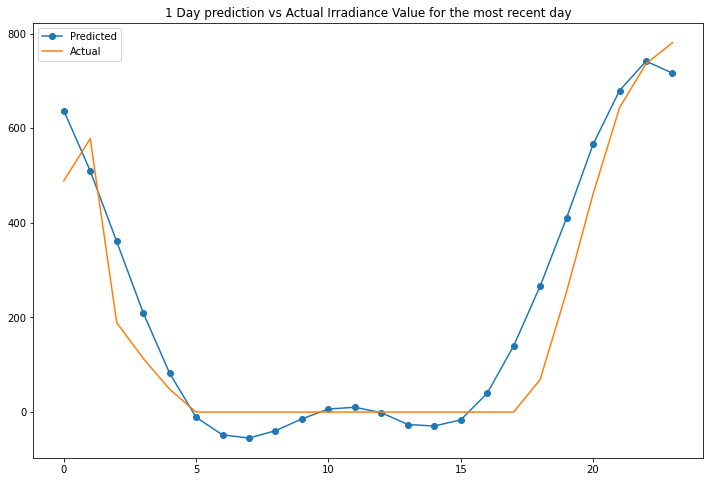

In [105]:
lstm(X_hour_train,y_hour_train,X_hour_test,y_hour_test)

Mean Squared Error :  297.36842015830086
R2 Score :  -0.6732996017025048


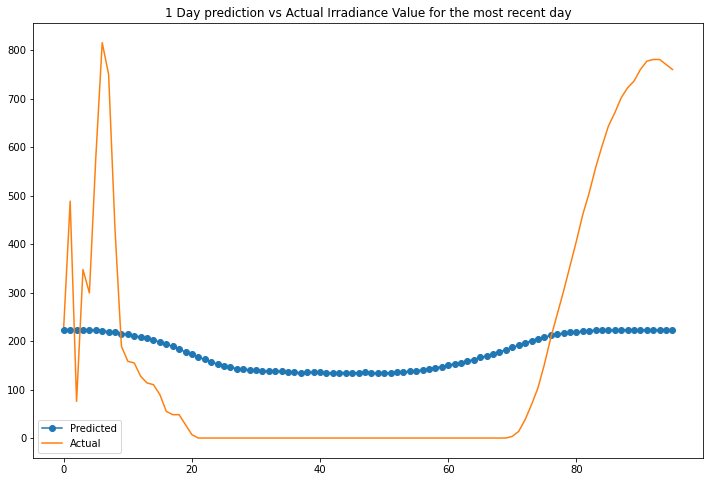

In [100]:
lstm(X_15m_train,y_15m_train,X_15m_test,y_15m_test)

In [112]:
lstm.fit(Xtrain,y_train,epochs=100,batch_size=10,validation_data=(Xtest,y_test),callbacks=[EarlyStopping(monitor='val_loss',patience=10)],shuffle=False)

Epoch 1/100
97/97 [==============================] - 8s 46ms/step - loss: 91955.6520 - val_loss: 146387.8750
Epoch 2/100
97/97 [==============================] - 3s 31ms/step - loss: 89569.2862 - val_loss: 142587.9219
Epoch 3/100
97/97 [==============================] - 3s 33ms/step - loss: 87360.5054 - val_loss: 139551.3125
Epoch 4/100
97/97 [==============================] - 3s 33ms/step - loss: 85566.7513 - val_loss: 136866.3125
Epoch 5/100
97/97 [==============================] - 3s 34ms/step - loss: 83982.8489 - val_loss: 134383.8906
Epoch 6/100
97/97 [==============================] - 3s 34ms/step - loss: 82524.9366 - val_loss: 132057.3438
Epoch 7/100
97/97 [==============================] - 4s 37ms/step - loss: 81190.9015 - val_loss: 129870.9688
Epoch 8/100
97/97 [==============================] - 3s 35ms/step - loss: 79958.8142 - val_loss: 127796.3203
Epoch 9/100
97/97 [==============================] - 3s 34ms/step - loss: 78808.9514 - val_loss: 125833.7109
Epoch 10/100
97/97 